# A3: Pipelines, Text, and Image Processing

## ***Learning Goals:*** Get additional experience in processing different types of data, explore cross-validation in more depth, and learn about text and image processing.


This assignment has **three parts:**
1. Classifying overall scores for Amazon products based on the text of their reviews.
2. Classifying pictures of cats vs non-cats
3. Classifying images of you based on a pre-existing dataset


**The assignment folder** has a number of files and folders. They relate to the parts of the assignment as follows:
This notebook (which you've apparently already found)

**Part1_Amazon_Reviews:**
* beauty_train.json - training data for reviews of Amazon products
* beauty_validation.json - validation data for reviews of Amazon products
* beauty_test.json - test data for reviews of Amazon products

**Part2_Cat_Classifying:**
* six examples images to show what the data looks like (Taro.jpg, Teru.jpg, Ruby.jpg, Mallow.jpg, Hubble.jpg, and Lake5.jpg)
* "cats" folder, contains 301 images of cats, some in .jpg format and some .png
* "scenery" folder, contains 333 images that don't contain humans or animals, all in .jpg format

**Part3_George_W_Bush:**
* "George_W_Bush" folder, contains 525 images of former US President George_W_Bush, all in .jpg format
* "You" folder, currently empty but will contain 5 images of you that you select

Note that throughout this notebook we're going to be using various packages that you may not have installed. If you encounter an error using one, check to make sure you've installed it. If you haven't, it should be easy to do so with conda.

## Part1: Classifying Amazon Reviews (25 pts total, up to 5 bonus points)

In this part of the assignment you'll use text from reviews of products on amazon.com to predict what overall score the reviewer gave the product. The dataset is from [here](http://jmcauley.ucsd.edu/data/amazon/). There were lots of different datasets to choose from, but we felt like going with beauty products this time to do something a little different.

There are three datasets within the Part1_Amazon_Reviews folder, one for each of training, validation, and test. There are 198502 reviews total across the dataset, and we've kind of arbitrarily separated them into 60% for training, 30% for validation, and 10% for testing... ish. The exact percentages don't matter too much here.

Take a look at what's inside the data. You can open it in a browser or a text editor. Both should show you tons of text. If you haven't seen .json data before, this is what it looks like. Each review object starts with a { and ends with a }, and contains a bunch of features separated by commas. Each feature has a name and a value.

**1.1 (2 points): In 13 words or less per feature, explain what you think each feature in the dataset means in the box below.**

In [1]:
print (len(("reviewerID is a unique id given to each user").split()) < 14)
print (len(("asin is a unique id given to each product").split()) < 14)
print (len(("reviewerName isthe display name of the user").split()) < 14)
print (len(("helpful is the helpfulness rating of the review, first over last").split()) < 14)
print (len(("reviewText is the review itself").split()) < 14)
print (len(("reviewerID is a unique id given to each user").split()) < 14)
print (len(("overall is the rating of the product out of five").split()) < 14)
print (len(("summary is a short summary of the review").split()) < 14)
print (len(("unixReviewTime is the time of the review in UNIX time").split()) < 14)
print (len(("reviewTime is the date of the review").split()) < 14)
# Keep going until you have all the features

True
True
True
True
True
True
True
True
True
True


### Importing the data

The first thing we have to do is import the data. Normally json data is really easy to import, but this file is in a slightly annoying format. Notably, the reviews don't have commas separating them. Fortunately this is pretty easy to overcome with a bit of iterating. For this assignment, we only care about the review text and the overall score within each review. To save you a bit of googling, you can access individual items within a json object by doing object["featurename"]. 

**1.2 (3 points): Import data into X and y arrays for train, validation and test sets.**

We'll give you the imports: 

In [2]:
import json
import numpy as np

# Put your resulting data in numpy arrays named: 
# "Train_X", "Train_y", "Validation_X", "Validation_y", "Test_X", and "Test_y" 
# with X as review text and y as overall score

# Your code goes here

Train_X = []
Train_y = []
Test_X = []
Test_y = []
Validation_y = []
Validation_X = []

with open('Part1_Amazon_Reviews//beauty_train.json') as f:
    for line in f:
        Train_X.append(json.loads(line)["reviewText"])
        Train_y.append(json.loads(line)["overall"])

with open('Part1_Amazon_Reviews//beauty_test.json') as f:
    for line in f:
        Test_X.append(json.loads(line)["reviewText"])
        Test_y.append(json.loads(line)["overall"])
        
with open('Part1_Amazon_Reviews//beauty_validation.json') as f:
    for line in f:
        Validation_X.append(json.loads(line)["reviewText"])
        Validation_y.append(json.loads(line)["overall"])

Train_X = np.asarray(Train_X)
Train_y = np.asarray(Train_y)
Test_X = np.asarray(Test_X)
Test_y = np.asarray(Test_y)
Validation_y = np.asarray(Validation_y)
Validation_X = np.asarray(Validation_X)


In [3]:
# If you've done this right, you should get (125398,) (125398,) (63104,) (63104,) (10000,) (10000,)
print (Train_X.shape, Train_y.shape, Validation_X.shape, Validation_y.shape, Test_X.shape, Test_y.shape)

(125398,) (125398,) (63104,) (63104,) (10000,) (10000,)


### Making a pipeline

We're going to test a how good a bunch of models are at predicting scores on this dataset. It would be cheating to keep training on the training set and testing on the test set, as you could just end up finding the model that bets fits that specific data rather than fitting a variety of data that you may not yet have seen.

Thus, we'll be using cross-validation. You've already seen a bit of this in A2, but [here](https://www.youtube.com/watch?v=fSytzGwwBVw) is an explanation. 

Before we get to that though, we're going to build a pipeline to prepare the text data to be classified and then build a classifier all in one step. [Here](https://www.youtube.com/watch?v=URdnFlZnlaE) is a rather lengthy explanation of what pipelines are. People have tons of different syntactical styles in writing pipelines, but we'll be using the syntax at 14:30 in the video above. It'll look something like this:

In [4]:
# Don't run this, it's just an example. The semicolon at the end isn't part of the pipeline.
"""


model = Pipeline([
    ('name of transform1', Transform1()), 
    ('name of transform2', Transform2()),  
    ('name of classifier',  Classifier()),
    ])

model.fit(X, y)

"""
;

''

So what's happening here? "model" is a Pipeline object. It's defined in the "model = ..." block, and used with model.fit(X, y). It works by taking whatever you put into it, in this case X, and y, and running them through each step in the Pipeline. Typically this means each step until the last will transform the data in some way, and the last step will fit a classifier to the transformed data. Once a Pipeline is finished, you can use it by calling one of the methods *of the final function in the pipeline*. For example, in order to call model.fit(X,y), the last function in the Pipeline needs to be a classifier as transformers don't have the .fit() method.

*Note that I'm using* *Pipeline* *rather than* *pipeline* *above, because these things all apply specifically to the Pipeline class in sklearn, but not necessarily to the broader concept of a ML pipeline*

What are the advantages of using a Pipeline? Well: 
1. It compresses a lot of code into a short, neat block.
2. It's easy to plop in or switch out different types of classifiers or transformers.
3. You only have to tell it what input data to use once at the very beginning. It knows to take the output of the first step and automatically input it into the second step, etc. etc.
4. You can easily access the data from every step of the process even after the process is complete. Pipeline stores them according to the name you gave the step.
5. You can easily re-use it. Instead of writing the code to clean/classify data each time, you can just call the Pipeline you've written. You could actually define a single Pipeline creation function in a file somewhere and just call it every time you do a particular type of project (e.g., text classification), and then you could clean/classify all in one line in every project just by importing and calling that Pipeline. If you want to edit your Pipeline process, you'd only have to update that one function and then all of your projects would subsequently use the same new Pipeline. 


Convinced yet? If not, that's cool. You're gonna do it anyways. In this pipeline you're going to have **three steps**. A CountVectorizer transformer, a TfidfTransformer, and a classifier. You'll play with a few different classifiers to see which one works best.

**1.3 (2 points) Look up the documentation for CountVectorizer and TfidfTransformer. For each, explain what it's going to do to your data in fewer than 30 words.**

In [5]:
print (len(("CountVectorizer counts the number of occurrences of each word in each of the dictionaries and creates a matrix of word frequencies ").split()) < 31)
print (len(("Tfidf traforms a matrix of word frequencies to term-frequency representation, which attempts to lessen the weight of words that occurr more frequently").split()) < 31)

True
True


Next, make a Pipeline. The first two steps will be the above two transformers. The third step will be a classifier. We'll be testing out five classifiers here: KNeighborsClassifier, MultinomialNB, LogisticRegression, RandomForestClassifier, and an additional one of your choice. Just put one in for now; we'll swap them in and out later.

Update 10/10/2018 2:49PM - It seems like KNeighbors is taking a long time to run on some computers. If it takes longer than 15 minutes, you can go ahead and substitute it for a different classifier of your choice in sklearn (still 5 total).

**1.4 (6 points) Build a Pipeline to do the above using the format shown in the model = Pipeline([ example above.**

We'll let you figure out the imports this time.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

model = Pipeline([
    ('countVec', CountVectorizer()), 
    ('tfidfTransfrom', TfidfTransformer()),  
    ('clf', LogisticRegression()),
    ])



# model.fit(Train_X, Train_y)

/Users/cbroms/.virtualenvs/working/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Next we're going to do some cross validation to test out how well each of the classifiers does on the data. 

**1.5a (6 points) In the cell below, run five-fold cross validation using each of the five classifiers from above using the cross_val_score function in sklearn.model_selection. For each classifier, output both the accuracy score and the weighted f1 score. Write down the averages of each of these over the five folds in the slots below.**

You can read about f1 scores in the cross_val_score documentation or [here](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html). Basically f1 is a complement to accuracy that incorporates both precision and recall.

NOTE: Make sure you're doing cross validation on your Validation datasets! To use the Train or Test sets defeats the whole purpose.

In [7]:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

# Your code goes here
# model.fit(Train_X, Train_y)

# acc = cross_val_score(model, Validation_X, Validation_y, cv=5).mean()
# y_pred = cross_val_predict(model, Test_X, Test_y, cv=5)

# print(f1_score(Test_y, y_pred, average='weighted'))
# print(acc)

# Write in your average values below. Three digits is fine:

print("KNeighborsClassifier_AvgAccuracy = 0.461")
print("KNeighborsClassifier_AvgF1 = 0.495")

print("MultinomialNB_AvgAccuracy = 0.578")
print("MultinomialNB_AvgF1 = 0.492")

print("LogisticRegression_AvgAccuracy = 0.656")
print("LogisticRegression_AvgF1 = 0.587")

print("RandomForestClassifier_AvgAccuracy = 0.584")
print("RandomForestClassifier_AvgF1 = 0.556")

print("PassiveAggressiveClassifier_AvgAccuracy = 0.618")
print("PassiveAggressiveClassifier_AvgF1 = 0.589")

KNeighborsClassifier_AvgAccuracy = 0.461
KNeighborsClassifier_AvgF1 = 0.495
MultinomialNB_AvgAccuracy = 0.578
MultinomialNB_AvgF1 = 0.492
LogisticRegression_AvgAccuracy = 0.656
LogisticRegression_AvgF1 = 0.587
RandomForestClassifier_AvgAccuracy = 0.584
RandomForestClassifier_AvgF1 = 0.556
PassiveAggressiveClassifier_AvgAccuracy = 0.618
PassiveAggressiveClassifier_AvgF1 = 0.589


**PART 1.5 OPTIONAL BONUS (3 points or 5 points): 3 points: Build a Pipeline that ends up getting you greater than 0.75 accuracy and greater than 0.65 weighted f1 score. You can use different or additional transformers and whatever classifier you want to use from anywhere, not necessarily just sklearn. Additional 2 points: get greater than 0.80 accuracy and greater than 0.7 weighted f1 score. This is going to be HARD, but there are definitely ways to do this classification far better than we just did. **

In [8]:
# Cell for optional part 1.5 bonus code

Finally it's time to see how the model really performs on test data. 

**1.6 (6 points) Pick the classifier that performed best above, then fit a model on your training data and predict on your test data. Print out your accuracy and f1 scores, and then print out the confusion matrix.**

In [10]:
# Your code goes here

from sklearn.metrics import confusion_matrix, accuracy_score

model = Pipeline([
    ('countVec', CountVectorizer()), 
    ('tfidfTransfrom', TfidfTransformer()),  
    ('clf', LogisticRegression()),
    ])

model.fit(Train_X, Train_y)

pred_y = cross_val_predict(model, Test_X, Test_y, cv=5)

print(confusion_matrix(Test_y, pred_y))
print("F1 Score: {}".format(f1_score(Test_y, pred_y, average='weighted')))
print("Accuracy: {}".format(accuracy_score(Test_y, pred_y, normalize=True)))

[[   0    1   23   29  120]
 [   0    0   63   60  188]
 [   0    3  121  289  512]
 [   0    2   55  566 1620]
 [   0    0   26  576 5746]]
F1 Score: 0.5878639101528499
Accuracy: 0.6433


/Users/cbroms/.virtualenvs/working/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Congrats! You've made a halfway-decent text classifer that does something vaguely useful!

## Part2: Classifying Cats (50 points total)

The next thing we're going to do is try to see if we can create a classifier to tell the difference between images of cats and images of non-cats. We'll be using the pleasantly-named "Pillow" fork of the Python Imaging Library (PIL). 

Starring in the cat images portion of this dataset are Taro, Teru, Rhubarb Penelope (Ruby), Mallow, and Hubble, all of whom are members of the 4th year HCII PhD cohort:

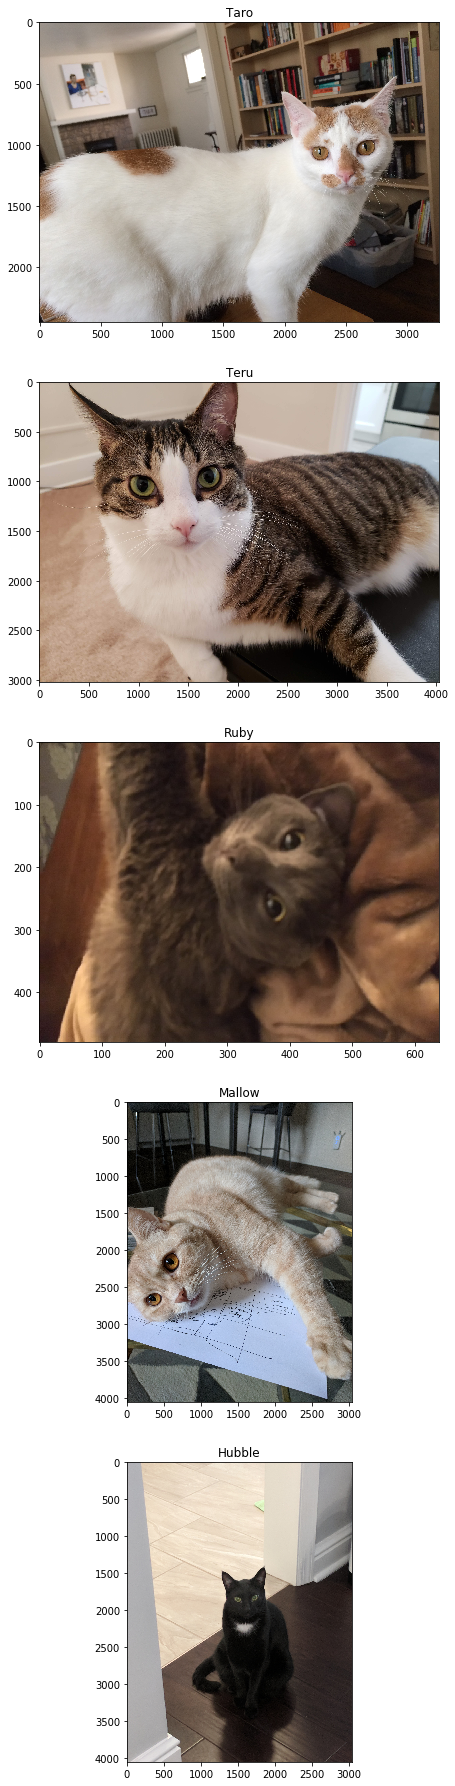

In [11]:
# Just run this. Also you can probably get some clues from this for your next steps. 
# We figured it was worth giving away answers to show pictures of these cats.
import PIL
from PIL import Image

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

fig=plt.figure(figsize=(32, 32))

img = Image.open('Part2_Cat_Classifying/Taro.jpg')
title = "Taro"
sp = plt.subplot(5, 1, 1)
sp.set_title(title)
plt.imshow(img)

img = Image.open('Part2_Cat_Classifying/Teru.jpg')
title = "Teru"
sp = plt.subplot(5, 1, 2)
sp.set_title(title)
plt.imshow(img)

img = Image.open('Part2_Cat_Classifying/Ruby.jpg')
title = "Ruby"
sp = plt.subplot(5, 1, 3)
sp.set_title(title)
plt.imshow(img)

img = Image.open('Part2_Cat_Classifying/Mallow.jpg')
title = "Mallow"
sp = plt.subplot(5, 1, 4)
sp.set_title(title)
plt.imshow(img)

img = Image.open('Part2_Cat_Classifying/Hubble.jpg')
title = "Hubble"
sp = plt.subplot(5, 1, 5)
sp.set_title(title)
plt.imshow(img)

The non-cat images are a subset of the OASIS image dataset by Benedek Kurdi, explained [here](http://www.benedekkurdi.com/#!portfolio/project-4.html). We've removed images from this dataset that show people or animals, just to try to make classification easier. 

*Because we're only using a subset of the OASIS dataset, please don't use these images for other projects. The full dataset is available for free download at the above link if you want to use it for another purpose*.

Example scenery image:

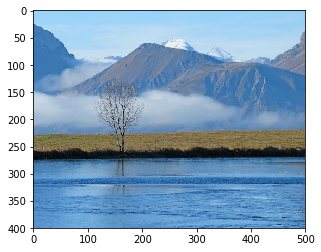

In [12]:
# Just run this
img = Image.open('Part2_Cat_Classifying/Lake5.jpg')
plt.imshow(img)

Unfortunately, the formal sklearn Pipeline function isn't actually terribly useful for this task. However, as it turns out, "pipeline" is a broader term that really just means the steps you do to import your data, clean it, visualize it, select features, model, and analyze results. Sklearn's Pipeline is a very common way to do this for some types of data, but you can do it manually for others (or you can write out functions to create your own version of Pipeline for a particular application).

Keep the structure of Pipelines in the back of your mind, though. We'll come back to it. 

Before we formally build our pipeline, let's just take a look at the data a bit and see what we can do with it. Here's a picture of Teru. You can see the dimensions of the picture (1920 x 2560) printed above it.

(1920, 2560)

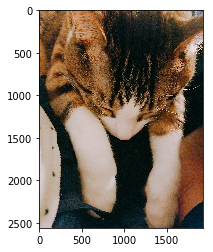

In [13]:
# Just run this

terupicture = Image.open('Part2_Cat_Classifying/cats/1.jpg')
plt.imshow(terupicture)
terupicture.size

Next we can take a look at what's actually stored within the data of this image. If you don't know how pixels work, [here](https://www.youtube.com/watch?v=lL0pxSslCzo) is a basic explanation. It's strikingly difficult to find a really clear tutorial of this online, but this is the best we found after a lot of googling. If this video is to be believed, the above cat picture should be represented by a whole lot of pixels (1920 times 2560, in fact) which are each made of three values from zero to 255 (representing Red, Green, and Blue respectively). This should look something like [12, 127, 56], [65, 208, 11], [34, 33, 2], ....

This notebook will just show you a limited subset of these (as printing out ~5 million would be a bit much).

In [14]:
teru_image_array = np.array(terupicture)
print(teru_image_array)

[[[214 193 190]
  [210 191 185]
  [211 194 187]
  ...
  [ 61  96 102]
  [ 62  97 103]
  [ 63  98 104]]

 [[209 190 186]
  [206 187 181]
  [207 190 183]
  ...
  [ 53  88  94]
  [ 53  88  94]
  [ 56  91  97]]

 [[208 189 185]
  [205 186 180]
  [207 190 183]
  ...
  [ 58  93  99]
  [ 59  94 100]
  [ 65 100 106]]

 ...

 [[195 179 166]
  [195 179 166]
  [196 180 167]
  ...
  [  2  46  71]
  [  7  51  76]
  [  6  52  78]]

 [[195 179 166]
  [195 179 166]
  [196 180 167]
  ...
  [  1  45  70]
  [  4  50  76]
  [  4  51  77]]

 [[195 179 166]
  [195 179 166]
  [196 180 167]
  ...
  [  1  47  71]
  [  3  50  76]
  [  4  51  77]]]


Voila, just as we expected. 

For the sake of image processing, let's **convert** this image to grayscale. Again, we'll expect to see values from 0 to 255, but this time it'll be a list of single numbers rather than groups of three.

**2.1 (3 points) Convert the image of Teru to grayscale. Show the new image, and then print out the array of numbers like we did above.**

HINT: You don't need to (and shouldn't) import anything else for this. There's already a function in something we've imported that will convert images to grayscale.

[[198 195 198 ...  86  87  88]
 [195 191 194 ...  78  78  81]
 [194 190 194 ...  83  84  90]
 ...
 [182 182 183 ...  35  40  41]
 [182 182 183 ...  34  39  39]
 [182 182 183 ...  35  38  39]]


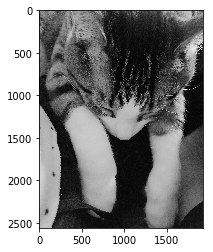

In [15]:
# Your code goes here
greyscale = terupicture.convert('L')
plt.imshow(greyscale)

grey_image_array = np.array(greyscale)
print(grey_image_array)

Again, this looks as expected. We can do some random other things with PIL like rotating the image or flipping it or cropping it.

**2.2a (1 point) Display a grayscale picture of Teru rotated 20 degrees counterclockwise**

**2.2b (1 point) Display a grayscale picture of Teru with the bottom 1000 pixels cropped off** 

HINT: again, no imports needed. The rotated picture will have some black space at the corners now. That's fine.

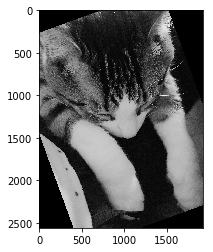

In [16]:
# Rotate here
rotated = greyscale.rotate(20)
plt.imshow(rotated)

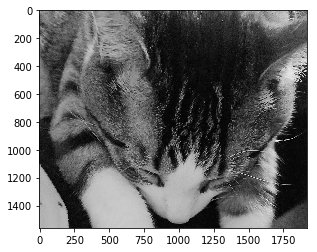

In [17]:
# Crop here
width, height = greyscale.size   # Get dimensions
cropped = greyscale.crop((0, 0, width, height-1000))
plt.imshow(cropped)

Image "Convolutions" are ways to do some math with the pixel values in images to transform them into something that's more useful for classification. [This](http://machinelearninguru.com/computer_vision/basics/convolution/image_convolution_1.html) has a nice explanation of what convolutions are, and we'll use some of the ones they talk about here.

**2.3 (2 points) Convolve your original gray Teru picture using the "sharpen" kernel they define, then display it.**

HINT: See import.

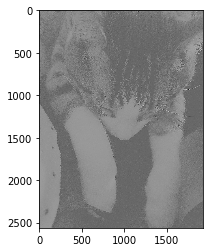

In [18]:
from scipy.signal import convolve2d

kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
gray_terupicture_sharpen = convolve2d(np.array(greyscale),kernel)
plt.imshow(gray_terupicture_sharpen, cmap=plt.cm.gray)

This'll look better if we equalize exposure. Don't worry too much about what this does- it basically just increases contrast.

/Users/cbroms/.virtualenvs/working/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


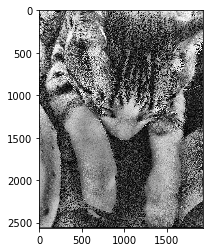

In [19]:
#Just run this. There'll be a UserWarning. That's fine.

from skimage import exposure
gray_terupicture_sharpen_equalized = exposure.equalize_adapthist(gray_terupicture_sharpen/np.max(np.abs(gray_terupicture_sharpen)), clip_limit=0.03)
plt.imshow(gray_terupicture_sharpen_equalized, cmap=plt.cm.gray)

Next let's try the edge detection kernel they specify, also equalizing exposure as shown above.

**2.4a (2 points) Convolve your ORIGINAL gray Teru picture using the edge detection kernel they define, then display it.**


/Users/cbroms/.virtualenvs/working/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


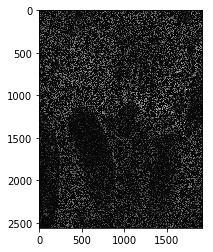

In [20]:
# Your code goes here

kernel = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
edges = convolve2d(np.array(greyscale),kernel, 'valid')

edges_equalize = exposure.equalize_adapthist(edges/np.max(np.abs(edges)), clip_limit=0.03)
plt.imshow(edges_equalize, cmap=plt.cm.gray)

It kinda sorta found the edges. Looks like it got tricked by fur patterns though.

**2.4b (1 point) Which one or two cats might edge processing work best on? Why?**

In [21]:
print("Hubble and Taro, as they are both mostly made up of high contrast colors that pop out from the background")

Hubble and Taro, as they are both mostly made up of high contrast colors that pop out from the background


Finally, let's try a kernel that isn't on the page. 

**2.5 (2 points) Go to the kernels wikipedia page and pick one of the three blur kernels and apply it here.**

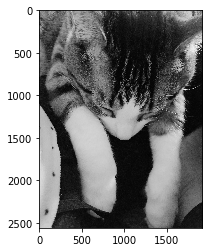

In [22]:
# Your code goes here

kernel = np.array([[1,2,1],[2,4,2],[1,2,1]])/16.0;
blur = convolve2d(np.array(greyscale),kernel, 'valid')
plt.imshow(blur, cmap=plt.cm.gray)

Okay, I think you get the picture (pun intended). 

Let's make a cat classifier. We'll follow the steps described above in the section where we talked about pipelines in image classification: import your data, clean it, visualize it, select features, model, and analyze results.

## Importing, cleaning, and visualizing your data

There are four arrays of data we need to import to get our classifier working, which we'll combine to get two final arrays that can be passed into a classifier:
1. An array of pictures of cats, cleaned.
2. An array of pictures of non-cats, cleaned.
3. An array that says all the pictures of cats are pictures of cats.
4. An array that says all the pictures of non-cats are pictures of non-cats.
5. Final - an X array with images, and a y array showing whether the images are of cats or not

Let's start with the first. The first thing you may notice if you scroll through the images in the "cats" folder is that some of the files are in .jpg format and a handful are .png.

Taro has classier owners than all of the other HCII cats, so some pictures of her are in .png format. For simplicity's sake, we want all of our images in .jpg format, **so write a script to convert them to .jpg**. Name the output something like "Taro1.jpg", "Taro2.jpg", etc. In order to do this, you're going to want to open each .png file in the folder individually in sequence and convert it to .jpg, saving it under a different name. I'll let you figure out how to do this, but note that the **glob** package makes it really easy to select all the files in a folder with a certain extension.

Note that you may get an error if you try to convert directly from .png to .jpg because .png images have a property (transparency) that .jpg files don't. We don't need this property here, so you can ignore the error if you get it.

**2.6 (2 points) Convert the .png files in the cats folder to .jpg files and re-save them as new files**

In [26]:
import glob
import os

for cat in glob.glob('Part2_Cat_Classifying/cats/phdcat*.jpg'):
  os.remove(cat)

for cat in glob.glob('Part2_Cat_Classifying/cats/Taro*.jpg'):
  os.remove(cat)

pngs = glob.glob('Part2_Cat_Classifying/cats/*.png')

count = 1
for img in pngs:
    bad_pic = Image.open(img)
    name = 'Part2_Cat_Classifying/cats/Taro' + str(count) + '.jpg'
    
    good = Image.new('RGB', bad_pic.size, (255, 255, 255))
    good.paste(bad_pic, (0, 0), bad_pic)
    good.save(name)
    count += 1

In [27]:

# If you've done this right up until now, the following should output 301
catfilelist = glob.glob('Part2_Cat_Classifying/cats/*.jpg')
print (len(catfilelist))

301


Finally, you might notice that the images have lots of different sizes and dimensions represented. Let's convert all the images to the same dimensions. This'll make some of them a little oddly-proportioned, but that's ok.

**2.7 (3 points) Import each of the .jpg files and** **resize** **them to 256x256 pixels. Then,** **convert** **these to grayscale, as we did for the cat image above. Re-save these images with names "phdcat0.jpg" through "phdcat300.jpg".**

(Sorry for your disk space, though they'll be fairly small files after this).

In [28]:
import os 

# Your code goes here
for cat in glob.glob('Part2_Cat_Classifying/cats/phdcat*.jpg'):
  os.remove(cat)

jpgs = glob.glob('Part2_Cat_Classifying/cats/*.jpg')
count = 0
for img in jpgs:
    bad_pic = Image.open(img)
    name = 'Part2_Cat_Classifying/cats/phdcat' + str(count) + '.jpg'
    
    good = Image.new('RGB', bad_pic.size, (255, 255, 255))
    good.paste(bad_pic)
    good = good.resize((256, 256))
    good = good.convert('L')
    good = good.save(name)
    count += 1

If you did this right, the following should again print out 301:

In [29]:
# Just run this
catfilelist = glob.glob('Part2_Cat_Classifying/cats/phdcat*.jpg')
print (len(catfilelist))

301


*(It's probably useful to remove the old .png files and original (color) .jpg images at this point, just in case you accidentally include them when you didn't mean to. You might want to save a copy of them somewhere in case you mess something up.)*

Now it's finally time to import the images into an array you can use for classification. 

**2.8a (2 points) Put all of the phdcats images in a numpy array called "catimages".**

HINT: this will actually be a numpy array of numpy arrays, where the large array contains an array for each of the pictures, and the picture arrays contain grayscale picture values.

In [30]:
# Your code goes here

cats = []

for cat in glob.glob('Part2_Cat_Classifying/cats/phdcat*.jpg'):
    img = Image.open(cat)
    cats.append(np.array(img))
    
catimages = np.asarray(cats)

**2.8b (1 point) What does the code below do? What do each of the numbers mean?**

In [31]:
print(catimages.shape)
print(catimages[0].shape)
print("this gives the dimensions of the array. It shows it containing 301 arrays of dimensions 256 by 256")

(301, 256, 256)
(256, 256)
this gives the dimensions of the array. It shows it containing 301 arrays of dimensions 256 by 256


Let's take a look at what's in this new numpy array to make sure it makes sense:

[[[118 123 127 ...  31  30  30]
  [111 116 121 ...  38  42  45]
  [120 122 124 ...  45  52  56]
  ...
  [ 73  71  70 ...  21  18  15]
  [ 74  72  70 ...  19  15  11]
  [ 74  73  71 ...  15  11   6]]

 [[ 66  18   8 ... 235 233 232]
  [ 74  22   0 ... 237 235 233]
  [ 75  33   1 ... 239 237 236]
  ...
  [  4   4   4 ... 150 180 180]
  [  4   4   4 ... 140 170 180]
  [  6   6   6 ... 143 164 178]]

 [[154 154 154 ... 183 183 182]
  [154 154 154 ... 183 183 182]
  [154 154 154 ... 184 183 183]
  ...
  [151 166 163 ... 163 163 163]
  [153 148 153 ... 162 161 161]
  [156 153 152 ... 160 160 160]]

 [[ 87 164 161 ... 254 254 254]
  [ 75 165 154 ... 254 254 254]
  [ 70 151 143 ... 254 254 254]
  ...
  [201 200 199 ...  88  63  60]
  [197 194 192 ...  67  64  63]
  [194 189 185 ...  40  79  91]]]


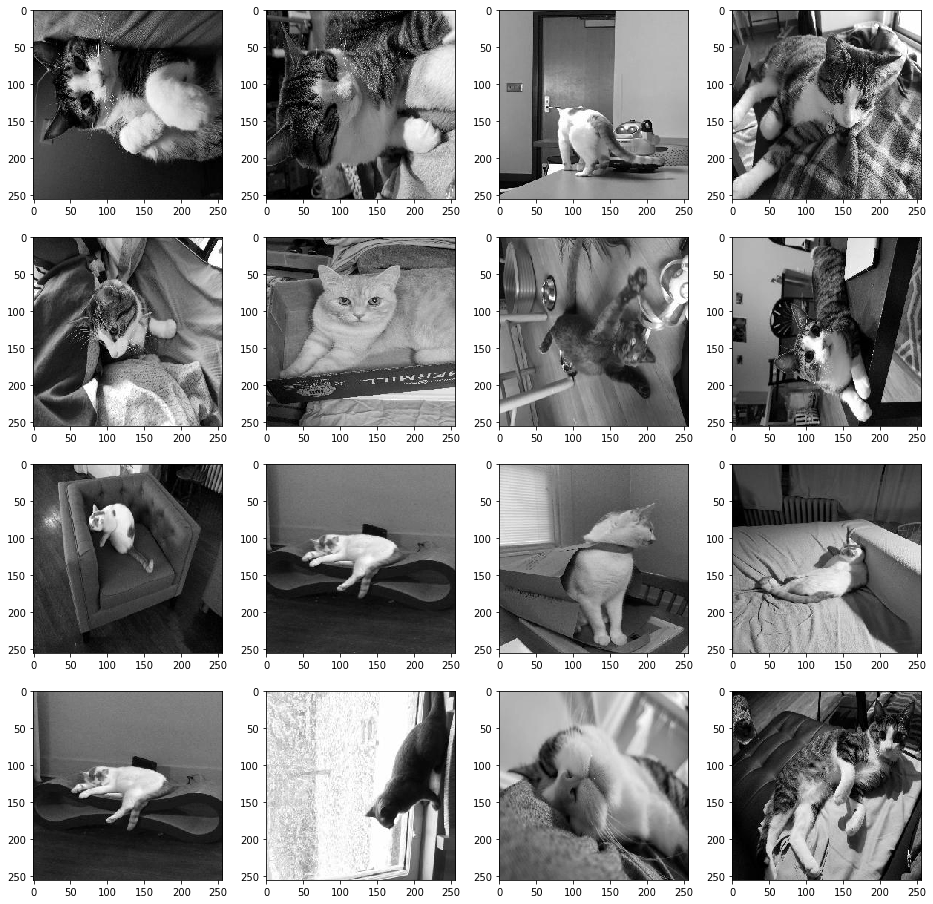

In [32]:
# Just run this.
# This makes a nice 4x4 display to show images numbers 0-15 in the array, 
# and the underlying numerical data for four of them

fig=plt.figure(figsize=(16, 16))
for i in range(1, 17):
    img = catimages[i-1]
    fig.add_subplot(4, 4, i)
    plt.imshow(img,cmap=plt.cm.gray)
    

print (catimages[:4])

Status checkpoint:

1. An array of pictures of cats, cleaned. (DONE)
2. An array of pictures of non-cats, cleaned.
3. An array that says all the pictures of cats are pictures of cats.
4. An array that says all the pictures of non-cats are pictures of non-cats.
5. Final - X array with images, and y array showing whether the images are of cats or not

You can do the exact same thing to clean and import the scenery pictures that you did for the cat pictures. Fortunately, they're all already .jpg files. 

**2.9 (3 points) Convert the scenery images to grayscale and 256x256, save them as "scenery0.jpg" through "scenery332.jpg" and then put them in a numpy array called "sceneryimages". Do this all in one cell below.**

*(Note that we're using the word "scenery" loosely here. They're just a bunch of images without animals or people in them)*

In [33]:
# Your code goes here

for scenery in glob.glob('Part2_Cat_Classifying/scenery/scenery*.jpg'):
  os.remove(scenery)

jpgs = glob.glob('Part2_Cat_Classifying/scenery/*.jpg')
count = 0
for img in jpgs:
    bad_pic = Image.open(img)
    name = 'Part2_Cat_Classifying/scenery/scenery' + str(count) + '.jpg'
    
    good = Image.new('RGB', bad_pic.size, (255, 255, 255))
    good.paste(bad_pic)
    good = good.resize((256, 256))
    good = good.convert('L')
    good = good.save(name)
    count += 1
    
scenery = []

for pic in glob.glob('Part2_Cat_Classifying/scenery/scenery*.jpg'):
    img = Image.open(pic)
    scenery.append(np.array(img))
    
sceneryimages = np.asarray(scenery)

In [34]:
# If you've done this correctly, this should print 333
print (len(sceneryimages)) 

333


*You'll probably want to remove the original scenery .jpg images here too and either delete them or save them somewhere else*

Run the following to double check your array:

[[[  0   1   3 ...  13  13  13]
  [  0   1   2 ...  13  13  13]
  [  0   0   2 ...  13  13  13]
  ...
  [  7   3   3 ...   7  15  22]
  [  3   0   4 ...   6  12  17]
  [  0   0   3 ...   4   6   9]]

 [[ 99 100 102 ...  21  19  17]
  [102 102 103 ...  21  19  17]
  [104 104 103 ...  21  18  17]
  ...
  [ 63  62  60 ...  91 101 110]
  [ 60  59  59 ...  86  98 107]
  [ 58  58  59 ...  83  95 105]]

 [[101 104 107 ... 176 177 179]
  [103 106 109 ... 176 178 179]
  [105 108 111 ... 177 179 180]
  ...
  [ 69  72  75 ...  45  41  38]
  [ 70  73  77 ...  42  37  33]
  [ 71  74  78 ...  39  34  30]]

 [[165 165 203 ...  98 108 124]
  [157 185 180 ...  97  98 148]
  [158 180 185 ... 101  90 176]
  ...
  [ 75 120 103 ...  38  39  40]
  [ 63 209 199 ...  47  48  49]
  [224 216 204 ...  58  59  60]]]


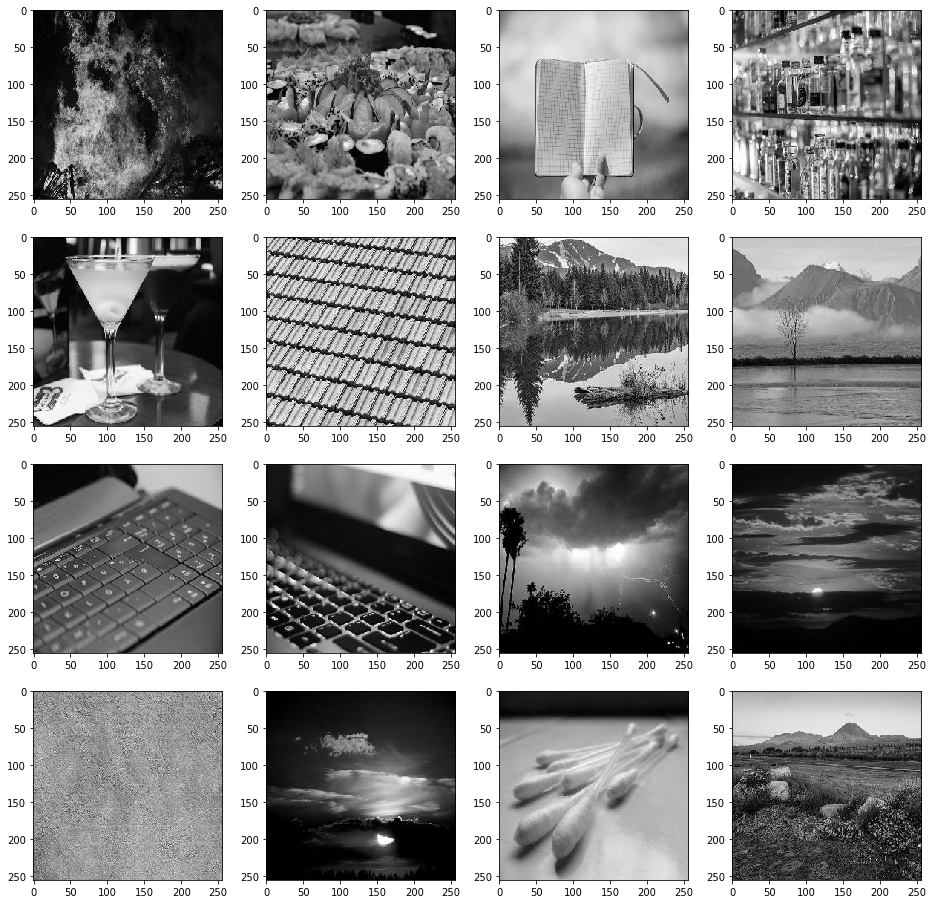

In [35]:
# This makes the same array for scenery images that we did above for cat images, just to take a look at what's there.

fig=plt.figure(figsize=(16, 16))
for i in range(1, 17):
    img = sceneryimages[i-1]
    fig.add_subplot(4, 4, i)
    plt.imshow(img,cmap=plt.cm.gray)
    

print (sceneryimages[:4])

Status checkpoint:

1. An array of pictures of cats, cleaned. (DONE)
2. An array of pictures of non-cats, cleaned. (DONE)
3. An array that says all the pictures of cats are pictures of cats.
4. An array that says all the pictures of non-cats are pictures of non-cats.
5. Final - X array with images, and y array showing whether the images are of cats or not

Now we have all of our images of cats and non-cats cleaned and imported into numpy arrays. This will serve the source for our Train_X, Validation_X, and Test_X sets once we smush the two arrays together. However, in order to train a classifier we need to give the classifier an array telling it which images are of cats and which are of non-cats (where 1 = cat, and 0 = non-cat). Since we've kept our two types of images separate, it's pretty easy to make an array of ones and an array of zeros and then smush those two arrays together.

Since we know the length of our catimages array and our sceneryimages array-
**2.10a (1 point) Make a one-dimensional array full of ones as long as the catimages array** 
**2.10b (1 point) Make a one-dimensional array full of zeros as long as the sceneryimages array**.

In [36]:
# Your code goes here
sceneryimages_y = np.zeros(len(sceneryimages))
catimages_y = np.ones(len(catimages))

In [37]:
# Should print 301 and 333:
print(len(catimages_y), len(sceneryimages_y))

301 333


Status checkpoint:

1. An array of pictures of cats, cleaned. (DONE)
2. An array of pictures of non-cats, cleaned. (DONE)
3. An array that says all the pictures of cats are pictures of cats. (DONE)
4. An array that says all the pictures of non-cats are pictures of non-cats. (DONE)
5. Final - X array with images, and y array showing whether the images are of cats or not

Now we need to smush the two images arrays together to get a final X array. One might call this process... conCATenating. [ba dum tss](https://i.imgur.com/ekQpV59.gifv)

**2.11 (2 point) Create a new array that's one dimensional and contains all the cat images followed by all of the secenery images**

In [38]:
# Your code goes here
xs = []

for cat in catimages:
    xs.append(cat)
    
for scenery in sceneryimages:
    xs.append(scenery)
    
All_X = np.asarray(xs)

In [39]:
# Should print (634, 256, 256)
print(All_X.shape)

(634, 256, 256)


Now smush the two y arrays together. Make sure you combine them in the correct order - if you put catimages first above, make sure to put catimages_y first here:

In [40]:
# Your code goes here
ys = []

for one in catimages_y:
    ys.append(one)
    
for zero in sceneryimages_y:
    ys.append(zero)
    
All_y = np.asarray(ys)

In [41]:
# Should print (634,)
print(All_y.shape)

(634,)


The following will show the first three, middle three, and last three images in your images array, along with the corresponding classifications. This is your last chance to make sure you've combined things properly, so if you have scenery images labeled as "1" or cat images labeled as "0", go back and figure out where things went wrong now.

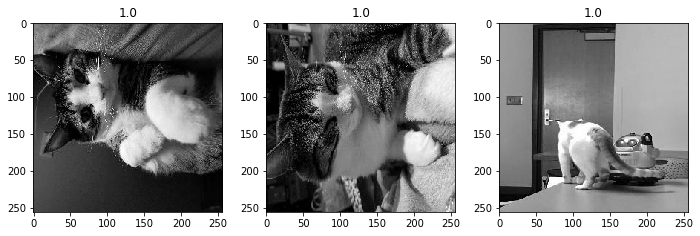

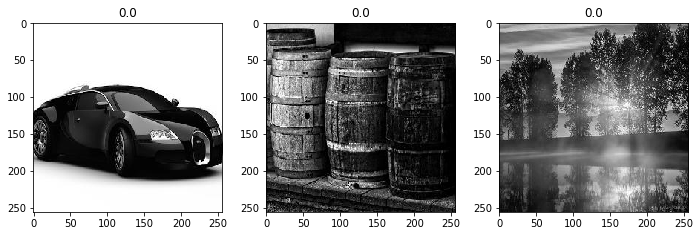

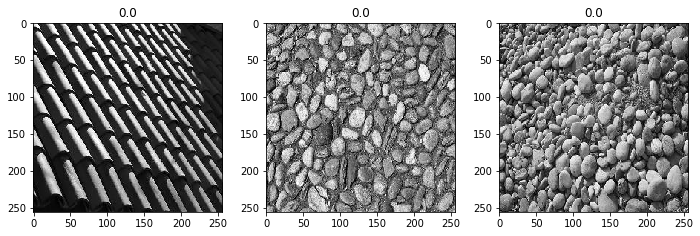

In [42]:
# Just run this
fig=plt.figure(figsize=(16, 16))
for i in range(1, 4):
    img = All_X[i-1]
    title = All_y[i-1]
    sp = plt.subplot(4, 4, i)
    sp.set_title(title)
    plt.imshow(img,cmap=plt.cm.gray)

fig=plt.figure(figsize=(16, 16))
for i in range(318, 321):
    img = All_X[i-1]
    title = All_y[i-1]
    sp = plt.subplot(4, 4, i-317)
    sp.set_title(title)
    plt.imshow(img,cmap=plt.cm.gray)
    
fig=plt.figure(figsize=(16, 16))
for i in range(632, 635):
    img = All_X[i-1]
    title = All_y[i-1]
    sp = plt.subplot(4, 4, i-631)
    sp.set_title(title)
    plt.imshow(img,cmap=plt.cm.gray)

One last step before we split these into train and test- we need to **flatten** them to two-dimensional arrays because that's what our classifiers will accept. This is pretty simple:

In [43]:
# Just run this
All_Flat_X = np.array([image.flatten() for image in All_X])
print(All_Flat_X.shape)

(634, 65536)


Now, as we did above, we need to split these final arrays into train, validation, and test sets randomly. Do this below. Let's do 60% of the data into training, 20% into validation, and 20% into testing. 

There are a ton of ways to do this, but we're giving you a hint that should lead you toward a very simple way. Note that you NEED to take a **random** subset here. If you just put the first 60% into train, and the next 40% split between validation and test, your validation and test sets will only have scenery images in them because your data isn't in a random order right now.

**2.12 (5 points) Split the data into X and y for Train, Validation, and Test sets**

In [ ]:
from sklearn.model_selection import train_test_split
# This only splits a numpy array into two random sub-arrays, 
# but if you're clever you can also use it to get a validation set with just one more line of code

# Your code goes here
Train_X, temp_X, Train_y, temp_y = train_test_split(All_Flat_X, All_y, test_size=0.4, train_size=0.6, shuffle=True)
Test_X, Validation_X, Test_y, Validation_y = train_test_split(temp_X, temp_y, test_size=0.5, train_size=0.5, shuffle=False)
# Print out the following
print (len(Train_X), len(Train_y), len(Test_X), len(Test_y), len(Validation_X), len(Validation_y))
print (Train_y)
print (Validation_y)
print (Test_y)
print (Train_X[0])

Alright, let's test out some classifiers. We'll use the same ones as we did above for the text classification task.

**2.13a (8 points) Train models based on each of the four classifiers listed here plus one more you pick. Write down average accuracy and F1 scores again as you did above.**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

# Your code goes here

# clf = MLPClassifier()

# clf.fit(Train_X, Train_y)

# acc = cross_val_score(clf, Validation_X, Validation_y, cv=5).mean()
# y_pred = cross_val_predict(clf, Test_X, Test_y, cv=5)

# print(f1_score(Test_y, y_pred, average='weighted'))
# print(acc)

#Write down the stats the same way as you did above, 3 digits is fine
print("KNeighborsClassifier_AvgAccuracy = 0.631")
print("KNeighborsClassifier_AvgF1 = 0.570")

print("MultinomialNB_AvgAccuracy = 0.488")
print("MultinomialNB_AvgF1 = 0.551")

print("LogisticRegression_AvgAccuracy = 0.575")
print("LogisticRegression_AvgF1 = 0.559")

print("RandomForestClassifier_AvgAccuracy = 0.535")
print("RandomForestClassifier_AvgF1 = 0.575")

print("MLPClassifier_AvgAccuracy = 0.512")
print("MLPClassifier_AvgF1 = 0.446")

**2.13b (8 points) Pick the best classifier you found and use it on the train and test data below. Print out your accuracy, weighted f1 score, and confusion matrix.**

There might not be a clear winner, so don't worry too much about which to pick

In [ ]:

# Your code goes here
clf = KNeighborsClassifier()

clf.fit(Train_X, Train_y)

pred_y = cross_val_predict(clf, Test_X, Test_y, cv=5)

print(confusion_matrix(Test_y, pred_y))
print("F1 Score: {}".format(f1_score(Test_y, pred_y, average='weighted')))
print("Accuracy: {}".format(accuracy_score(Test_y, pred_y, normalize=True)))

**2.13c (2 points) What would your accuracy be if you had just picked the** ***majority*** **class from the training set every time?** **Be careful you know what the majority class is!**

In [ ]:
# Your code goes here
ones = 0
zeros = 0

for obj in Test_y:
    if obj == 0:
        ones += 1
    else:
        zeros += 1

if ones > zeros:
    accuracy = ones / len(Test_y)
else:
    accuracy = zeros / len(Test_y)
    
print (accuracy)

Okay. If your results are anything like ours, your classifier is very slightly better than random at guessing which images have cats in them. 

As it turns out, image classification is a really hard problem, and in the process of cleaning this data we've removed a whole lot of information. We took away the color, made the images smaller and changed them away from their natural aspect ratios, and we flattened them out. 

We tried very hard in writing this assignment to scaffold creation of a *good* image classifier from the ground up, but we couldn't find a way to do it that didn't involve a lot of hand-waving and saying "trust us". So we had you make a pretty bad image classifier from the ground up.

There are (for better or worse) lots of premade image classification algorithms that do much better on most datasets. In fact, if you google/youtube around for image classification you'll find almost nobody recommending an approach that involves building a classifier from scratch. Most everybody just says use TensorFlow. The following section is entirely optional **(but don't forget about the third section that follows it, which is NOT optional!)**. You'll get some bonus points if you do this optional section, and you can see what a really high-accuracy image classifier looks like (kinda). Hopefully you'll also get to have some idea of what TensorFlow is, and it's a very widely used package in industry right now.

# OPTIONAL BONUS SECTION: TensorFlow and Cats (Up to 7 bonus points)

## (But note that there's another mandatory section below this optional section)

TensorFlow is an open source library from Google that does a variety of things across data science including complex classifications. It's hard to find an answer to what exactly TensorFlow *does* that's comprehensible to a layperson. The closest approximation is that TensorFlow has a bunch of super-long premade pipelines for different applications where they've found all sorts of data convolutions and other math to transform data that makes subsequent classification of it better.

We're going to quickly run through a TensorFlow image classification model using tf.keras.

This code and the code in the "BONUS_tensorflow-for-poets-2" folder is pulled (slightly modified) from TensorFlow's tutorial [here](https://codelabs.developers.google.com/codelabs/tensorflow-for-poets/?utm_campaign=chrome_series_machinelearning_063016&utm_source=gdev&utm_medium=yt-desc#0)

Note that first you'll have to install a (slightly older) version of TensorFlow. This script seems to rely on an older version and they haven't updated it, but you can updgrade to the newest version later if you want. Command to install is pip install --upgrade "tensorflow==1.7.*"

In [ ]:
# Use a terminal/console to navigate to the BONUS_tensorflow-for-poets-2 folder that you downloaded.
# Paste the following into terminal once you're there. (Don't paste the triple quotes or semicolon)
"""
python -m scripts.retrain \
  --bottleneck_dir=tf_files/bottlenecks \
  --how_many_training_steps=500 \
  --model_dir=tf_files/models/ \
  --summaries_dir=tf_files/training_summaries/"mobilenet_0.50_224" \
  --output_graph=tf_files/retrained_graph.pb \
  --output_labels=tf_files/retrained_labels.txt \
  --architecture="mobilenet_0.50_224" \
  --image_dir=tf_files/catsvsnotcats/
"""
;

**BONUS.1 (0.5 point each, 4 points total): Explain what the inputs to retrain.py above do in no more than 15 words for each.**

In [ ]:
print (len(("Input 1 does ... Your explanation ").split()) < 16)
print (len(("Input 2 does ... Your explanation ").split()) < 16)
print (len(("Input 3 does ... Your explanation ").split()) < 16)
#Keep going up to 8

While the output of the script is whizzing by, you'll see lots of accuracy numbers that are probably very high. MUCH higher than the previous model. Your final accuracy should probably be higher than 95%, if not 100% on the test data.

Let's see how it does on some individual images we held out:

In [ ]:
# While in the same folder in the terminal, paste the following script. 
# It'll make a prediction for one of the files we held out of the training
"""
python -m scripts.label_image \
    --graph=tf_files/retrained_graph.pb  \
    --image=tf_files/heldout/phdcat286.jpg
"""
;

You might get an output that looks something like this:

"cats (score=0.98744)
scenery (score=0.01256)"

That basically means that it's really sure that it's a cat, which is correct in this case (which is kind of impressive given how little of the cat is shown in this particular image). You can try it on any of the other images in the heldout folder, and it'll give you similar predictions.

This model is going to be REALLY good at identifying cats vs not cat images from this dataset. How exactly does it work, you ask? 

¯\\_(ツ)_/¯ No idea. But it works!

Let's try to see if we can fool TensorFlow.

**BONUS.2 (1 point or 3 points): Find an image of a cat somewhere online that wasn't included in this dataset. It must have only one cat, and no other animals or humans. All of the cat must be visible such that a human could easily tell that there's a cat in the picture. 1 point: get it so TensorFlow is less than 80% sure that there's a cat in the picture, based on the model you train on the phdcats data. 2 additional points: get it so TensorFlow guesses incorrectly that you have a picture of scenery. Display the image you found below along with the cats and scenery scores you found.**

You might have to try a few pictures to get this to work. No cheating by blurring or scribbling over or otherwise screwing with your image is allowed!



## Part3: Building a George W Bush classifier to classify yourself (25 points total, up to 10 bonus points)

This is the final part of the assignment!

Labeled Faces in the Wild ([LFW](http://vis-www.cs.umass.edu/lfw/)) is a well-known repository of human faces originally based on people who were in the news about a decade ago. The most common face in the database is former US president George W. Bush, who was president at the time.

Through subsequent work, the original authors of the database have attached values for 73 attributes to each image, from "Pale Skin" to "Senior" to "Eyeglasses" to "Male", where a higher value indicates that the image is more representative of this label. The basis of these attributes comes from MTurk worker ratings, but a variety of fancy math led to the values they have now. You can see the full file with attributes for all of the 13,000+ images in the dataset [here](http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt). 

For this activity, we're going to be working off a dataset made entirely of images of George W. Bush. You can find these images in the appropriately-named "George_W_Bush" folder, along with a file called "bushattributes.csv" that shows the attributes of each of the images. If you look in this csv file, you can see that images of Bush are generally labeled with values > 0 in the dataset for Male, White, and not wearing lipstick, and < 0 for Black, Baby, and Heavy Makeup. Seems reasonable, as Bush is White and Male and doesn't usually wear lipstick. For whatever it's worth, the average "Attractive Man" score for Bush is slightly higher than the overall average in the Labeled Faces in the Wild dataset.

As there is variance in the attributes among all of these images (e.g., Bush has a higher "White" score in some images), we can train a classifier on these images and use it to predict attributes of other unseen images. A reasonable-ish (though low-quality result) exercise would be to use this to predict attributes of other images in the dataset. An unreasonable thing to do would be to have it predict attributes of images of you, which, of course, is what we're going to do.

### Step 1: Import

Our importing won't be quite as easy as for the cat pictures because we can't just set all attributes to 1 or 0. We need to make sure we're importing in the same order for the images and for the attributes. Note that we've already converted the images to gray for you, though we've kept them at their original dimensions of 250x250. In the original dataset they're 250x250 and color.

**3.1 (1 points): Import the images of George W Bush into a numpy array called bushimages.**

In [44]:
# Your code goes here
bush = []

for bushy in glob.glob('Part3_George_W_Bush/George_W_Bush/*.jpg'):
    img = Image.open(bushy)
    bush.append(np.array(img))
    
bushimages = np.asarray(bush)

In [45]:
#Should return 524

print(len(bushimages))

524


As we did a bunch of times above, let's double check what we have in the array.

**3.2 (1 points): Plot the first 16 images in your array in a 4x4 grid, and output the numerical contents of the first four of them, just as we did above**

[[[  0   0   0 ...   2   0   1]
  [  0   0   0 ...   2   0   0]
  [  0   0   0 ...   0   1   1]
  ...
  [ 16  17  18 ...  21  18  18]
  [ 14  15  16 ...  17  20  21]
  [ 14  15  16 ...  17  20  21]]

 [[241 241 241 ... 236 236 236]
  [241 241 241 ... 235 236 236]
  [241 241 241 ... 233 232 232]
  ...
  [ 42  28  17 ...  12  12  12]
  [ 42  29  17 ...  12  12  12]
  [ 42  29  17 ...  12  12  12]]

 [[ 85  85  85 ...  55  62  60]
  [ 83  84  84 ...  50  55  52]
  [ 82  83  84 ...  44  46  44]
  ...
  [ 83  84  85 ...  24  22  22]
  [ 80  83  85 ...  21  21  22]
  [ 80  83  85 ...  21  21  22]]

 [[  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  ...
  [  0   0   0 ...  24  20  20]
  [  0   0   0 ...  20  21  21]
  [  0   0   0 ...   7   7   7]]]


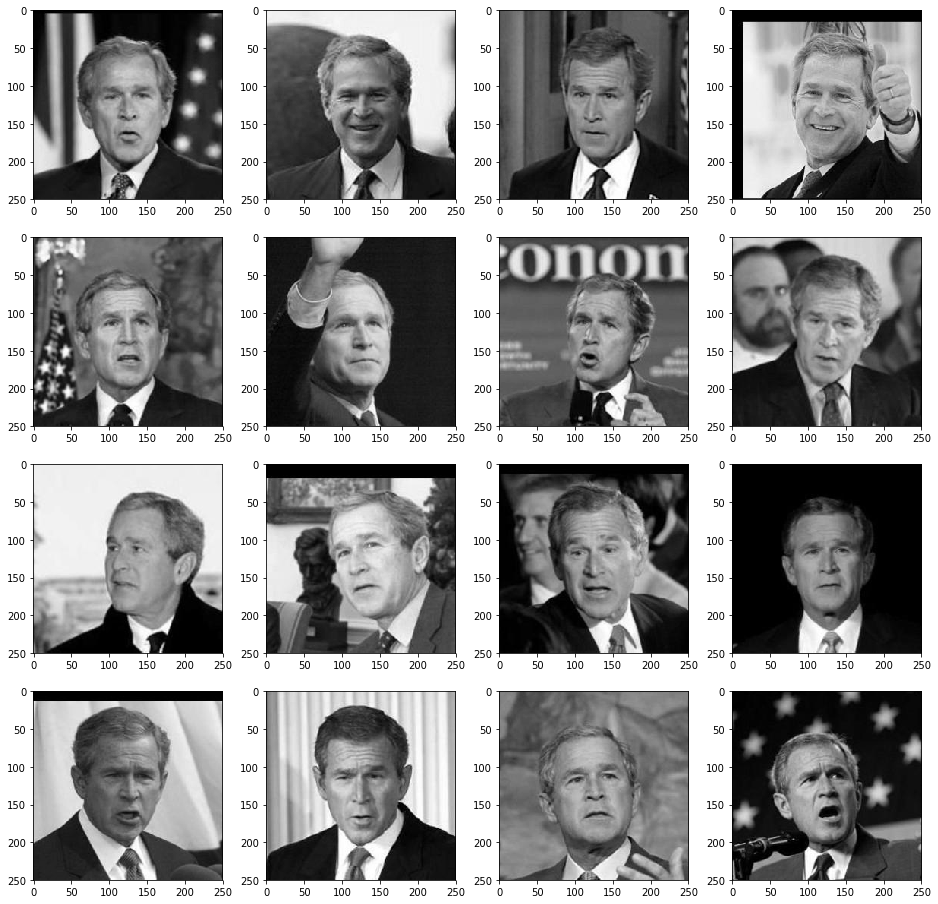

In [66]:
# Let's make sure the first 16 images are what we expect them to be:
# Just run this

fig=plt.figure(figsize=(16, 16))
for i in range(1, 17):
    img = bushimages[i-1]
    fig.add_subplot(4, 4, i)
    plt.imshow(img,cmap=plt.cm.gray)
    
print (bushimages[:4])

**3.3 (1 points): Flatten these images, as we did in the cats/scenery part above.**

In [47]:
# Your code goes here
All_Bush_Flat_X = np.array([image.flatten() for image in bushimages])

In [48]:
# Should print (524, 62500)
print(All_Bush_Flat_X.shape)

(524, 62500)


Next we need to come up with what we're going to predict. We can do this by importing columns from the bushattributes csv file. *If you need some hints, you can look back at A1 where you imported stuff from csv files.*

**3.4 (1 points): Import all of the attributes from the bushattributes.csv file. Attribute names should be column headers and rows should be the photo the attribute is tied to.**

In [49]:
# Your code goes here
import pandas

bushatts = pandas.read_csv('Part3_George_W_Bush/George_W_Bush/bushattributes.csv', header = 0)
bushatts = bushatts._get_numeric_data()

The things we want to predict need to be one-dimensional arrays with length equal to the number of photos (524, in this case). 

**3.5 (1 points): Create separate numpy output arrays for the "Male", "White", "Black", "Asian", "Eyeglasses", and "Mouth Closed" columns. Then, pick any three other attributes you'd like to predict out of the 73 and create output arrays for these too.**

In [62]:
# Your code goes here
male = bushatts["Male"]
white = bushatts["White"]
black = bushatts["Black"]
asian = bushatts["Asian"]
eyeglasses = bushatts["Eyeglasses"]
mouth = bushatts["Mouth Closed"]
attractive = bushatts["Attractive Man"]
cheeks = bushatts["High Cheekbones"]
stash = bushatts["Mustache"]



We took care of the validation etc. testing for you this time. Results: all the models are pretty bad. But that's okay, we've got enough to pitch to get VC dollars. *(That was a joke. Mostly).*

Go ahead and use **ExtraTreesRegressor** as a classifier. It'll take a while to run, but it's among the least terrible. As before, you can take a random subset of the data if you need to for your computing power. Just include the code that you used to take the random sample.

**3.6 (4 points): Put five images of yourself in the "You" folder and convert them to grayscale and 250x250 (you can use whatever images you like, you won't need to submit them to us so you'll be the only one to see them). Then import them and flatten them and use them as a set to make predictions on using this classifier. Run the classifier nine times - once to predict each of the six attributes we specified above for all five of your photos, and once to predict each of the three attributes that you chose for all five of your photos.**

Save the numbers you get each time somewhere, but please don't copy/paste the code into nine successive cells- just keep it in one cell and edit the predicted array each time. It'll make this much easier for us to read.

Grab a drink or find something good on Netflix - these models take a while to run. On the three-year-old PowerBook that this is being written on, it's taking about two minutes per model.

In [81]:
# Your code goes here
from sklearn.ensemble import ExtraTreesRegressor

for me in glob.glob('Part3_George_W_Bush/You/me*.jpg'):
  os.remove(me)

jpgs = glob.glob('Part3_George_W_Bush/You/*.jpg')
count = 0
for img in jpgs:
    bad_pic = Image.open(img)
    name = 'Part3_George_W_Bush/You/me' + str(count) + '.jpg'
    good = Image.new('RGB', bad_pic.size, (255, 255, 255))
    good.paste(bad_pic)
    good = good.resize((250, 250))
    good = good.convert('L')
    good = good.save(name)
    count += 1
    
me = []

for you in glob.glob('Part3_George_W_Bush/You/me*.jpg'):
    img = Image.open(you)
    me.append(np.array(img))
    
meimages = np.asarray(me)
All_Me_Flat_X = np.array([image.flatten() for image in meimages])
len(All_Me_Flat_X)

# for me in All_Bush_Flat_X:
#     print(me)
clf = ExtraTreesRegressor()


clf.fit(All_Bush_Flat_X, stash)

res = clf.predict(All_Me_Flat_X)

res.mean()


-0.6007723691800001

Okay. With that all done: 

**3.7 (0.33 points each): On a scale of 1-5 for each, how well did the classifier classify your images for each of the above attributes?**

In [82]:
#Fill in below:

"Male: 1.59603650154"

"White: 0.9409372145100001"

"Black: -1.7945276361399998"

"Asian: -1.5993153319400002"

"Eyeglasses: -0.5280537219"

"Mouth closed: 0.030254115280000014"

"Attractive Man: -0.39978427972"

"High Cheekbones: -0.41356855878000004"

"Mustache: -0.6007723691800001"
;

''

A model trained exclusively on pictures of George W. Bush is clearly going to be a biased dataset, as the data is not at all representative of... anybody other than George W. Bush, really.

As noted above, the broader dataset here comes from photos of people in the news in the mid-2000s, and George W. Bush is the most-represented person in this dataset.

**3.8 (3 points) Where (presumably other than news articles from the mid-2000s) would you scrape faces from to get a dataset that you think would be quite diverse but also that you'd be confident faces like yours would be represented in? Why did you pick this dataset? (no more than 50 words).**

In [106]:
print (len(("The dataset of all the images of students from the HUB. Each student at CMU has an image associated with them. This set would a pretty good representation of people my age, though based on CMU's admissions stats, probably a bit asian-biased but still pretty diverse").split()) < 51)


True


**3.9 (2 points each, 10 total): Assuming this classifier achieved significantly better scores for model quality than it currently does, which of the following would you be comfortable using it for? Why or why not? (30 words or less for each).**

In [107]:
# Picking which photos of you are most attractive to use on Tinder/Grindr/Bumble/Coffee Meets Bagel/OkCupid...
print (len(("If you think there is some sort of universal attractiveness, sure, I guess it might work.").split()) < 31)
# Automating your Tinder swiping by picking people who are above a certain attractiveness threshhold.
# (This has actually been done, though not with the George W Bush dataset)
print (len(("This fits with the philosophy of the users of Tinder, so sure. It would work best if you first provide some attractiveness scores for training to improve per-user accuracy").split()) < 31)
# Automatically detecting race in photos of college applicants to verify what they enter.
print (len(("No. Mostly because I'm opposed to using categories such as race or gender in applications. It could also produce a false positive and that would be disqualifying to the applicant.").split()) < 31)
# Detecting people who are wearing glasses in their Facebook photos in order to target glasses ads to them
print (len(("Sure. If you put photos on facebook, expect to get targeted ads such as these. The cost of false pos/negs are relatively low for the advertisers").split()) < 31)
# Looking at professional photos of speakers at an event to count how many speakers are female
print (len(("If this was the most efficient way to measure that number, I guess. It seems like it would produce a relatively inaccurate number as opposed to just counting").split()) < 31)


True
True
True
True
True


**3.10 (BONUS, up to 5 points): Go download the full Labeled Faces in the Wild attributes csv, the one with 13,000+ rows. You DO NOT have to download all the photos. For all nine of the attributes you've been using above, find the average value across the whole dataset. Next, go skim the paper where they talk about how the attribute values were generated. What do each of these attributes mean? (no word limit, but be kind to us)**

In [ ]:
# Your bonus response here

**3.11 (BONUS, up to 3 points): Find the total range of values (max-min) for each of the nine attributes in the full csv. Should be around 5 to 10. What proportion of this total range for each attribute is covered by the range in the George Bush attributes? (no word limit, but again be kind to us)**

In [ ]:
# Your bonus response here

Once you've completed all of the above, you're done with assignment 3! You might want to double check that your code works like you expect. You can do this by choosing "Restart & Run All" in the Kernel menu. If it outputs errors, you may want to go back and check what you've done.

Once you think everything is set, please run ALL of your code, download your final notebook as HTML, and submit to the A3 folder on the Canvas site with name `[yourandrewid]_haiif18a[assignmentnumber]`, e.g., `jseering_haiif18a3.`